In [3]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2

from smc.smc import sequential_monte_carlo
from smc.sampling_algorithms import (
    systematic_resample,
    stratified_resample,
    multinomial_resample
)
from smc.utils import lambda_schedule
from datasets import checkerboard

from smc_scripts.plot_utils import plot_smc_results_checkerboard
from smc.proposals import (
    reverse_as_proposal, 
    first_order_approximation_optimal_proposal, 
    first_order_approximation_optimal_proposal_with_gradient_clipping
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


## Load pre-trained mdm model

In [4]:
from models.discrete_diffusion.mdm import MaskedDiffusion
from models.discrete_diffusion.utils.parametrizations import (
    subs_parametrization,
    subs_parametrization_continuous_v1 as subs_parametrization_continuous,
)
from models.denoising_models.mlp import MLP

batch_size = 64
vocab_size = 256
num_categories = vocab_size + 1  #includes the mask category
mask_index = num_categories - 1
input_shape = (2,)
num_timesteps = 100

pretrained_model = MaskedDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=256,
        encode_time=False,
        n_hidden_layers=2,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
pretrained_model.load_state_dict(torch.load('../model_weights/mdm_checkerboard_256.pth'))

pretrained_model_with_subs_continuous = MaskedDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=256,
        encode_time=False,
        n_hidden_layers=2,
        probs_parametrization_fn=subs_parametrization_continuous,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
pretrained_model_with_subs_continuous.load_state_dict(torch.load('../model_weights/mdm_checkerboard_256.pth'))

<All keys matched successfully>

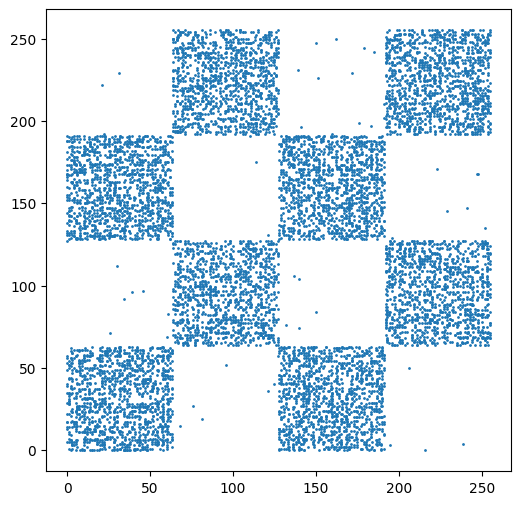

In [5]:
# Visualize pre-trained model samples
pretrained_model.eval()
with torch.no_grad():
    samples = pretrained_model.sample(num_samples=10000, device=device).cpu().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=1)
plt.show()

## Define Reward, KL penalty coefficient, and Corresponding Target Distribution

In [48]:
def compute_rewards(x: Tensor, with_grad=False):
    # x.shape : (B, 2, num_categories)
    
    x0 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    x1 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    
    low_left_corner = torch.cat([torch.ones(vocab_size // 4), torch.zeros(3 * vocab_size // 4)]).to(x.device)
    up_right_corner = torch.cat([torch.zeros(3 * vocab_size // 4), torch.ones(vocab_size // 4)]).to(x.device)
    
    reward_low_left_corner = (x[:, 0, :-1] * low_left_corner + x[:, 1, :-1] * low_left_corner).sum(dim=-1)
    reward_up_right_corner = (x[:, 0, :-1] * up_right_corner + x[:, 1, :-1] * up_right_corner).sum(dim=-1)
    
    reward = torch.max(torch.stack([reward_low_left_corner, reward_up_right_corner], dim=1), dim=1)[0]
    return reward

kl_weight = 1/4.

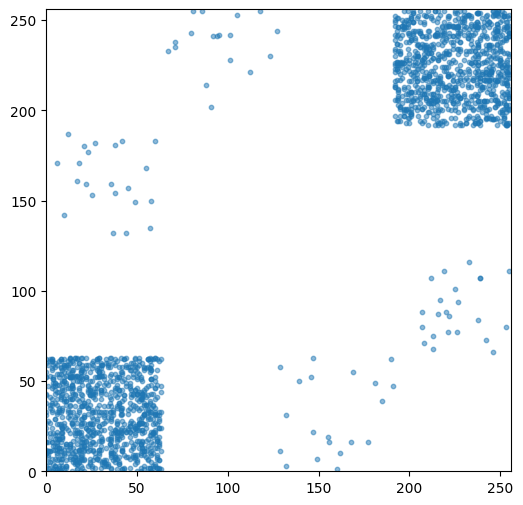

Target Reward: 1.9585000276565552
Diversity: 1760


In [49]:
def target_distribution_log_pdf(x, kl_weight):
    reward = compute_rewards(F.one_hot(x, num_classes=num_categories).float())
    return reward / kl_weight

def sample_target_distribution(n_samples, kl_weight):
    samples = checkerboard.generate_samples(n_grid_points=vocab_size, batch_size=n_samples * 100)
    log_pdf_values = target_distribution_log_pdf(samples, kl_weight)
    indices = torch.distributions.Categorical(logits=log_pdf_values).sample((n_samples,))
    return samples[indices]

target_samples = sample_target_distribution(2000, kl_weight)

plt.figure(figsize=(6, 6))
plt.scatter(target_samples[:, 0], target_samples[:, 1], s=10, alpha=0.5)
plt.xlim(0, vocab_size)
plt.ylim(0, vocab_size)
plt.show()

target_rewards = compute_rewards(F.one_hot(target_samples, num_classes=num_categories).float())
print(f"Target Reward: {target_rewards.mean().item()}")
print(f"Diversity: {np.unique(target_samples, axis=0).shape[0]}")

In [37]:
def intialize_particles(num_particles, device=device):
    particles = torch.full((num_particles, *input_shape), mask_index, device=device, requires_grad=False)
    return particles

num_particles = 2000
ESS_min = num_particles / 2
reward_estimate_sample_count = 100
# lambdas = lambda_schedule(num_timesteps)
lambdas = np.linspace(0, 1, num_timesteps + 1)
perform_final_resample = False

## Locally Optimal proposal

In [50]:
def compute_reward_for_x0_pred(x_0_probs: Tensor, reward_estimate_sample_count: int):
    N, L, C = x_0_probs.shape
    # Shape: (reward_estimate_sample_count, N, L)
    x_0_preds = torch.distributions.Categorical(x_0_probs).sample((reward_estimate_sample_count,))
    rewards = compute_rewards(
        F.one_hot(x_0_preds.reshape(reward_estimate_sample_count * N, -1), num_classes=num_categories).float()
    ).view(reward_estimate_sample_count, N).mean(dim=0)
    return rewards

def locally_optimal_proposal(X_t, x_s_probs, t, lambdas, kl_weight, rewards_grad, model, reward_estimate_sample_count) -> tuple[Tensor, Tensor]:
    """
    Returns:
        tuple[Tensor, Tensor]: A tuple containing the proposed samples and their log probabilities.
    """
    N = len(X_t)
    
    if not hasattr(locally_optimal_proposal, "all_rewards"):
        all_rewards = torch.zeros(vocab_size + 1, vocab_size + 1, device=device)
        # Both variables are unmasked, x0_pred is fixed
        fixed = torch.stack(torch.meshgrid(torch.arange(vocab_size), torch.arange(vocab_size), indexing='ij'), dim=-1)
        all_rewards[:vocab_size, :vocab_size] = compute_rewards(F.one_hot(fixed.reshape(-1, 2), num_classes=num_categories).float()).reshape(vocab_size, vocab_size)
        locally_optimal_proposal.all_rewards = all_rewards
    else:
        all_rewards = locally_optimal_proposal.all_rewards
    
    if t-1 != 0:
        # variable 0 unmasked, variable 1 masked
        with torch.no_grad():
            _, x_0_probs = model.sample_step(
                F.one_hot(torch.stack([torch.arange(vocab_size + 1, device=device), torch.full((vocab_size + 1,), mask_index, device=device)], dim=1), num_classes=num_categories).float(), 
                t-1, device=device)
        rewards = compute_reward_for_x0_pred(x_0_probs, reward_estimate_sample_count=reward_estimate_sample_count)
        all_rewards[:vocab_size + 1, mask_index] = rewards
        # variable 0 masked, variable 1 unmasked
        with torch.no_grad():
            _, x_0_probs = model.sample_step(
                F.one_hot(torch.stack([torch.full((vocab_size,), mask_index, device=device), torch.arange(vocab_size, device=device)], dim=1), num_classes=num_categories).float(), 
                t-1, device=device)
        rewards = compute_reward_for_x0_pred(x_0_probs, reward_estimate_sample_count=reward_estimate_sample_count)
        all_rewards[mask_index, :vocab_size] = rewards
        
    log_joint = torch.log(x_s_probs[:, 0, :].unsqueeze(2)) + torch.log(x_s_probs[:, 1, :].unsqueeze(1))
    log_joint += (lambdas[t-1] / kl_weight) * all_rewards.unsqueeze(0)
    log_joint -= torch.logsumexp(log_joint, dim=(1, 2), keepdim=True)
    
    indices = torch.multinomial(torch.exp(log_joint).reshape(N, -1), 1)
    X_s  = torch.cat([indices // (vocab_size + 1), indices % (vocab_size + 1)], dim=1)
    log_prob_proposal = log_joint[torch.arange(N), X_s[:, 0], X_s[:, 1]]
    
    return X_s, log_prob_proposal

100%|██████████| 100/100 [00:13<00:00,  7.43it/s]


Resampled 3 times.


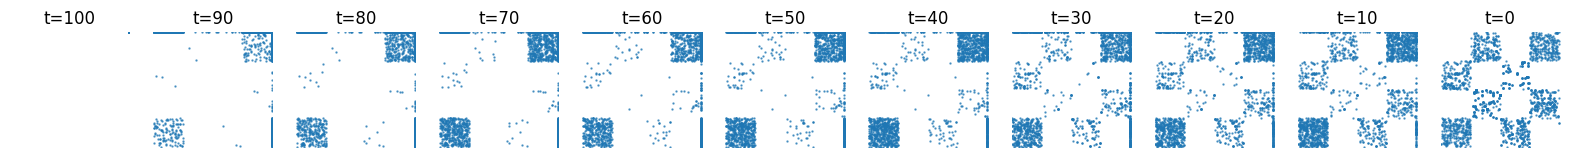

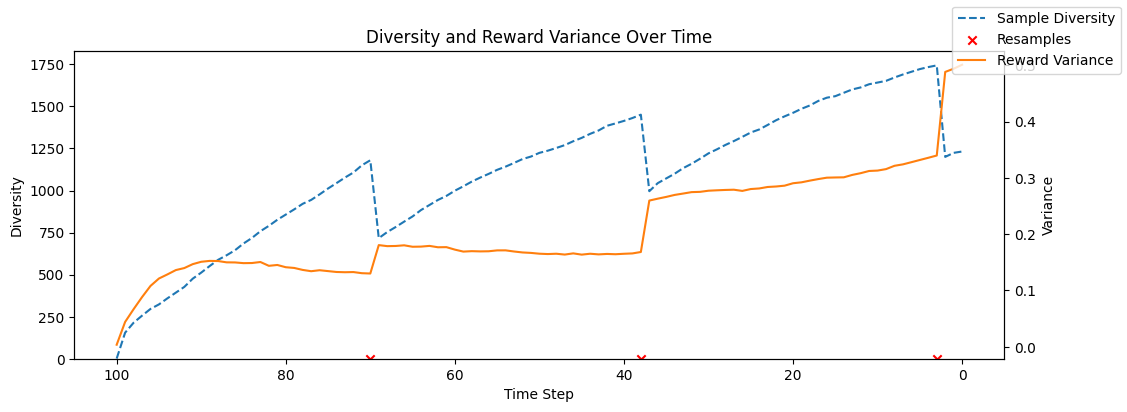

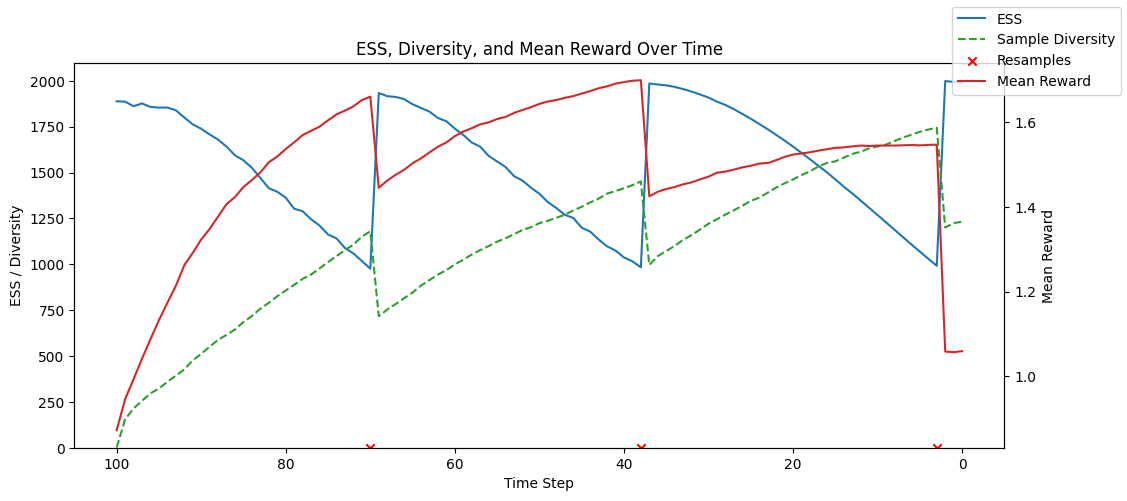

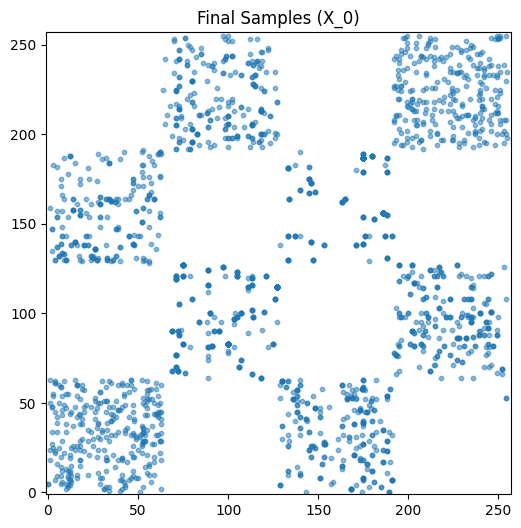

Final average reward: 1.0595
Final diversity: 1232
EMD: 75.23836777105394


{'reward': 1.059499979019165, 'diversity': 1232, 'emd': 75.23836777105394}

In [51]:
locally_optimal_proposal_results = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=ESS_min,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=locally_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    perform_final_resample=perform_final_resample,
    device=device,
    verbose=False,
)
plot_smc_results_checkerboard(locally_optimal_proposal_results, num_timesteps, vocab_size, num_categories, compute_rewards, target_samples=target_samples)

## Reverse diffusion as proposal

100%|██████████| 100/100 [00:09<00:00, 10.73it/s]


Resampled 11 times.


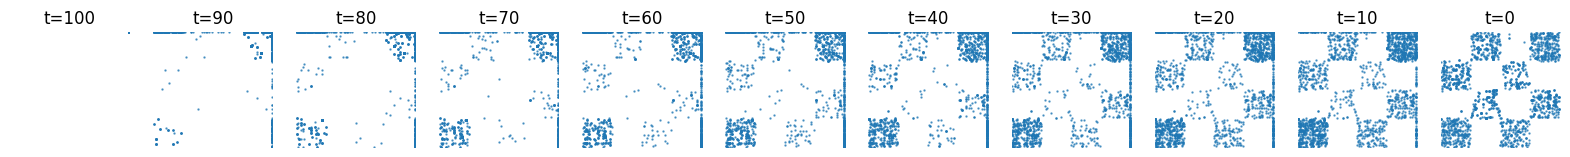

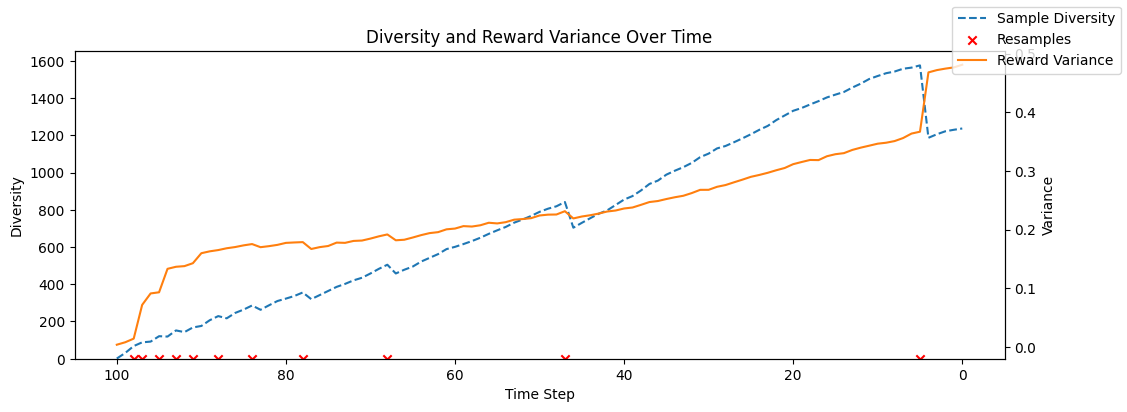

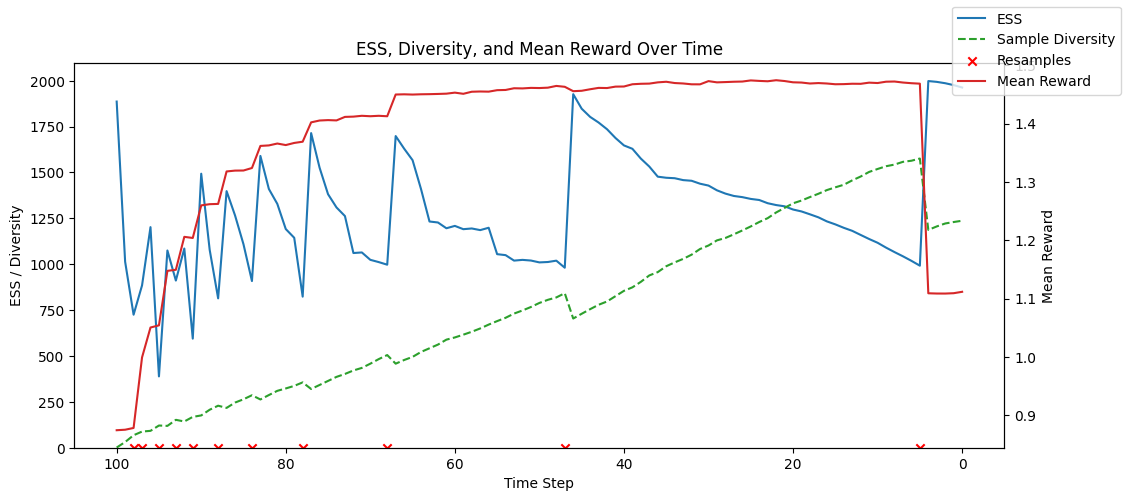

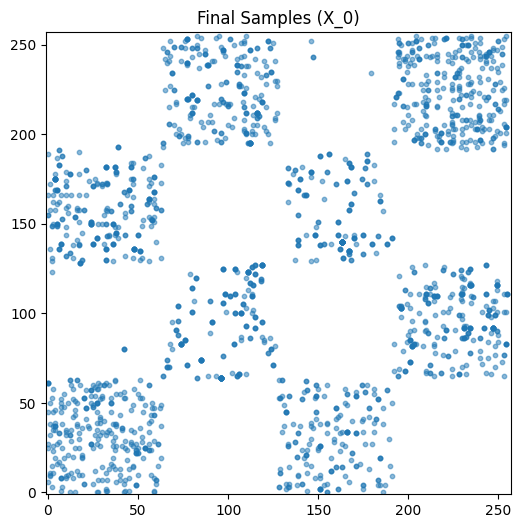

Final average reward: 1.1115
Final diversity: 1237
EMD: 72.3090177395203


{'reward': 1.1115000247955322, 'diversity': 1237, 'emd': 72.3090177395203}

In [52]:
reverse_as_proposal_results = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=ESS_min,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=reverse_as_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    perform_final_resample=perform_final_resample,
    device=device,
    verbose=False,
)
plot_smc_results_checkerboard(reverse_as_proposal_results, num_timesteps, vocab_size, num_categories, compute_rewards, target_samples=target_samples)

## First order approximate proposal

In [ ]:
first_order_approximate_results = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=ESS_min,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    perform_final_resample=perform_final_resample,
    device=device,
    verbose=False,
)
plot_smc_results_checkerboard(first_order_approximate_results, num_timesteps, vocab_size, num_categories, compute_rewards, target_samples=target_samples)

## First order approximate proposal with continuos formulation of subs parametrization

100%|██████████| 100/100 [00:09<00:00, 10.71it/s]


Resampled 0 times.


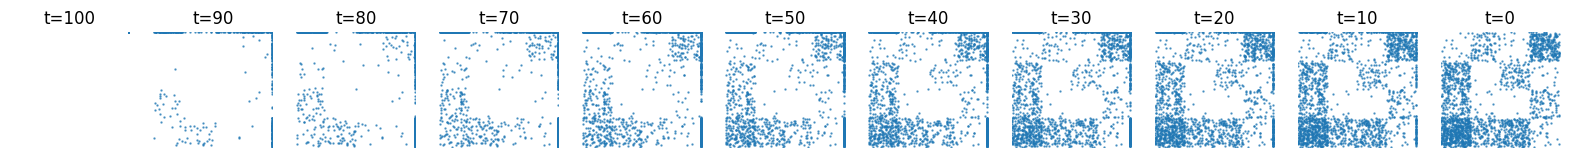

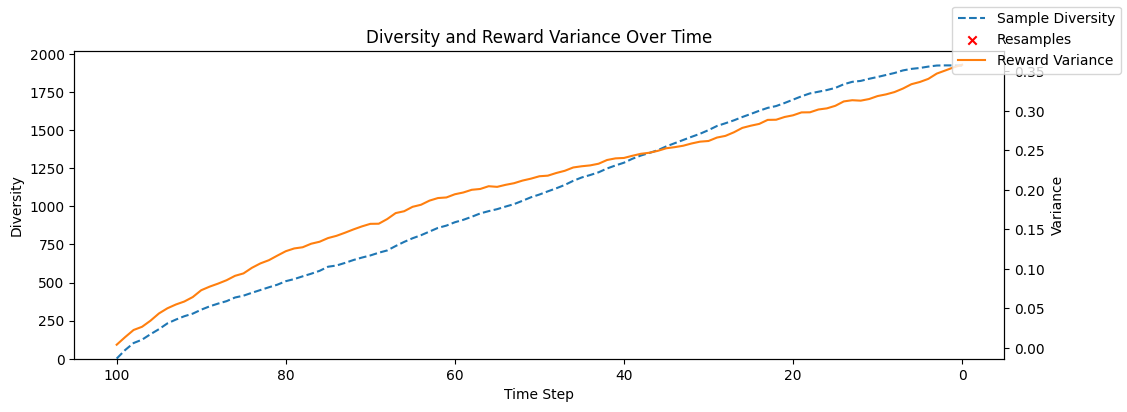

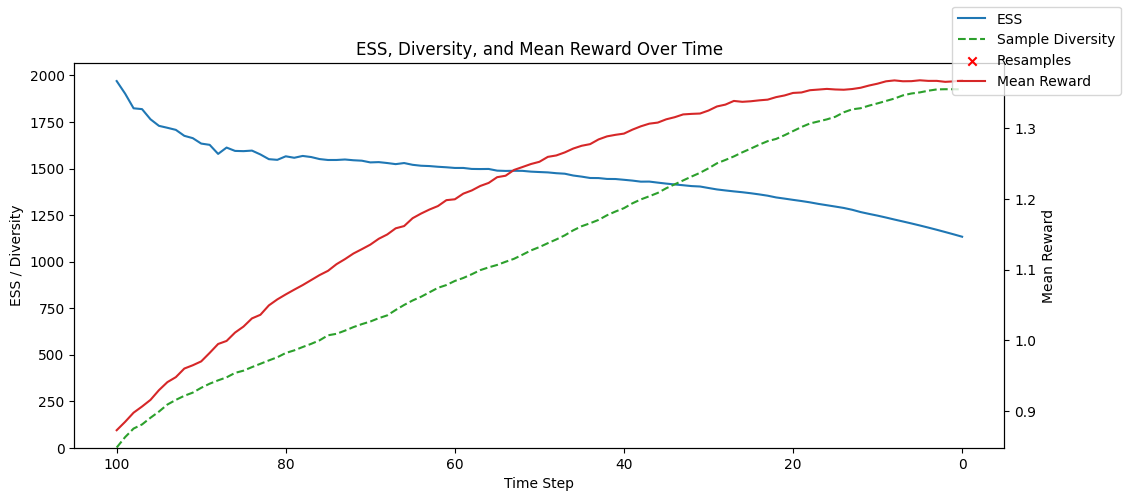

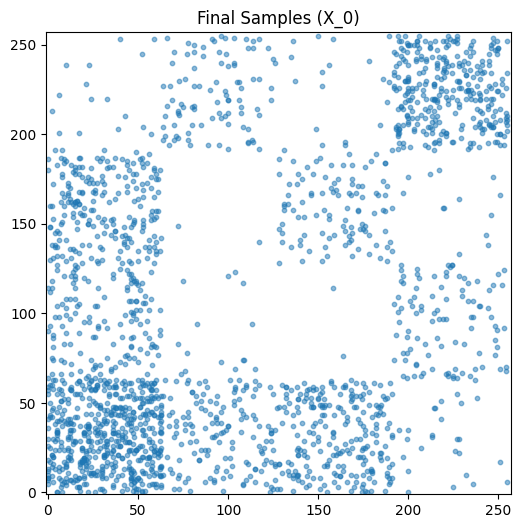

Final average reward: 1.3680
Final diversity: 1925
EMD: 53.96823682995034


{'reward': 1.3680000305175781, 'diversity': 1925, 'emd': 53.96823682995034}

In [47]:
first_order_approximate_continuous_results = sequential_monte_carlo(
    model=pretrained_model_with_subs_continuous,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=ESS_min,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    perform_final_resample=perform_final_resample,
    device=device,
    verbose=False,
)
plot_smc_results_checkerboard(first_order_approximate_continuous_results, num_timesteps, vocab_size, num_categories, compute_rewards, target_samples=target_samples)

## First order approximate proposal with continuos formulation of subs parametrization and gradient clipping

In [ ]:
num_particles = 2000
lambdas = lambda_schedule(num_timesteps)

X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model_with_subs_continuous,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=num_particles / 2,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal_with_gradient_clipping(gradient_clip_value=10),
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=100,
    device=device,
    verbose=False,
)

In [ ]:
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

### Use a reward function with bad gradients

In [ ]:
def compute_rewards_bad(x: Tensor, with_grad=False):
    # x.shape : (B, 2, num_categories)
    
    original_reward = compute_rewards(x, with_grad=False)
    
    x = (x[:, : , :-1] * torch.arange(0, vocab_size, device=x.device)).sum(dim=-1)
    x = x / (vocab_size - 1)
    
    reward_x0 = - (x[:, 0] - 0.5) ** 2 * 10
    reward_x1 = - (x[:, 1] - 0.5) ** 2 * 100
    
    reward = reward_x0 + reward_x1
    
    assert torch.allclose(reward, original_reward)
    return reward


In [ ]:
num_particles = 2000
lambdas = lambda_schedule(num_timesteps)

X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model_with_subs_continuous,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=num_particles / 2,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal_with_gradient_clipping(gradient_clip_value=10),
    compute_reward_fn=compute_rewards_bad,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=100,
    device=device,
    verbose=False,
)

In [ ]:
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)